# GAN

# Abstract

The GAN consists of a Generator and Discriminator that works as follows -
The generator takes in random numbers/noise and returns an image.This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset. The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.Two neural networks contest with each other in a game (in the sense of game theory, often but not always in the form of a zero-sum game). Given a training set, this technique learns to generate new data with the same statistics as the training set. For example, a GAN trained on photographs can generate new photographs that look at least superficially authentic to human observers, having many realistic characteristics.One neural network, called the generator, generates new data instances, while the other, the discriminator, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data that it reviews belongs to the actual training dataset or not.

# Dataset

Celebrity images dataset consists of 100,000 images - 100k of 128x128 celebrities' images. Cropped faces from CelebA dataset.
Link  from kaggle - https://www.kaggle.com/greg115/celebrities-100k/activity

### Importing required libraries --

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, UpSampling2D,Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import relu
from PIL import Image
import sys
import os
import numpy as np
import glob

### Loading dataset

In [5]:
img_rows = 64
img_cols = 64
channels = 3
image_shape=(64,64,3)
img_size = (img_rows, img_cols, channels)

In [6]:
def load_dataset(batch_size, image_shape, data_dir):
    sample_dim = (batch_size,) + image_shape
    print(sample_dim)
    sample = np.empty(sample_dim, dtype=np.float32)
    all_data_dirlist = list(glob.glob(data_dir))
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = np.asarray(image)
        image = (image/127.5) -1 # normalizing data
        sample[index,...] = image
    return sample

In [7]:
X_train = load_dataset(100000, (64,64,3), "C:/Python/.ipynb_checkpoints/100k/*.jpg")

(100000, 64, 64, 3)


In [8]:
print(X_train.shape)

(100000, 64, 64, 3)


In [9]:
print(X_train.shape[0])

100000



Bad key "text.kerning_factor" on line 4 in
C:\Users\chait\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


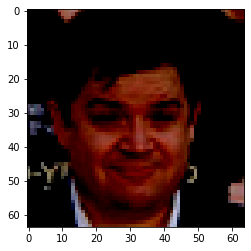

In [10]:
import matplotlib.pyplot as plt
import random
randomNum = random.randint(0,100000)
image = X_train[randomNum]
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [11]:
img_rows = 28
img_cols = 28
channels = 3
img_shape = (img_rows, img_cols, channels)

## Model 1 

### Generator

The generator is creating new, synthetic images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The goal of the generator is to generate fake images to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake. Using Keras Sequential model along with Dense and Batch Normalization layers we are building the generator. The activation function used is relu.The generator model is divided into several blocks. Each block consisting of Dense Layer, Activation and Batch Normalization. Six such blocks are added and the last block transforms the pixels into the desired shape of the image we’re expecting as the output which is (64,64,3). The input to the model will be a noise vector of shape (100,) and the model is returned at the end.

In [154]:
def build_generator():
    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    print(noise)
    
    model = Sequential()
    model.add(Dense(64 * 4 * 4,activation="relu", input_shape=noise_shape))
    model.add(Reshape((4,4,64)))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(16, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    output_img = model(noise)

    return Model(noise, output_img)

## Descriminator

A discriminator that tells how real an image is, is basically a deep Convolutional Neural Network (CNN). It classifies between  the real and fake images. For this Dataset, the input is an image (64 pixel x 64 pixel x 3 channel). The sigmoid output is a scalar value of the probability of how real the image is (0.0 is certainly fake, 1.0 is certainly real). A strided convolution is used for downsampling. The activation function used in each CNN layer is a leaky ReLU. A dropout between layers prevent over fitting and memorization.
The discriminator takes in an input of an image, flatten it and pass it through blocks of Activation and Batch Normalization, to finally output a scalar between 1 and 0. Output 1 should represent that the input image is real and 0 otherwise.


In [155]:
def build_discriminator():
    model = Sequential()
    img = Input(shape=img_size)
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    validity = model(img)
    
    return Model(img, validity)

###  Building the model

Building the Model with following hyperparameters such as momentum = 0.8,     alpha = 0.25 and also using adam optimizer with learning rate = 0.0002, beta_1 = 0.5.                                                                             
Alpha — α is a hyperparameter which controls the underlying value to which the function saturates negatives network inputs also known as step size. The proportion that weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values meaning slow learning right down during training of the model
beta_1 - The exponential decay rate that describes the process of reducing an amount by a consistent percentage rate over a period of time.
Momentum — This is a technique used in Neural Networks to speed up the training speed and improve accuracy.

In [156]:
# Build and compile the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002,beta_1=0.5))

Tensor("input_23:0", shape=(None, 100), dtype=float32)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              103424    
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
up_sampling2d_36 (UpSampling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
activation_48 (Activation)   (None, 8, 8, 128)         0         
________________________________________________________________

Generator network takes noise as an input to produce its images.

In [157]:
# The generator takes noise as input and generates imgs
noise = Input(shape=(100,))
generated_image = generator(noise)

In [158]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002,beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 16, 16, 64)      

Discriminator will take the images generated by our Generator and set its output to a parameter called validity, which will indicate whether the input is real or not.

In [159]:
# The discriminator takes generated images as input and determines validity
validity = discriminator(generated_image)
print(validity)
gan = Model(noise, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002,beta_1=0.5))

Tensor("model_17/Identity:0", shape=(None, 1), dtype=float32)


# Training GAN

In [160]:
dc_loss = []
gn_loss = []
def train1(epochs, batch_size, save_interval):
    global discriminator, generator, gan
    half_batch = int(batch_size / 2)
    print(half_batch)
    for epoch in range(epochs):

        #  Train Discriminator
        real_ids = np.random.randint(0, X_train.shape[0], half_batch)
        #print(real_ids)
        real_imgs = X_train[real_ids]

        noise = np.random.normal(0, 1, (half_batch, 100))
        #print(noise)
        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)
        #print(gen_imgs)

        # Train the discriminator
        real_loss = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        #print(real_loss)
        fake_loss = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        #print(fake_loss)
        d_loss = 0.5 * np.add(real_loss, fake_loss)
        #print(d_loss)
        #  Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        #print(noise)
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        #print(g_loss)
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        dc_loss.append(d_loss[0])
        gn_loss.append(g_loss)
        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
        
            gen_imgs = 0.5 * gen_imgs + 0.5
            fig, axs = plt.subplots(5, 5)
            for i in range(5):
                for j in range(5):
                    axs[i,j].imshow(gen_imgs[i*5+j])
                    axs[i,j].axis('off')

            fig.savefig("results1/animes_%d.png" % epoch, dpi=600, bbox_inches='tight')
            plt.close()    


Epochs dictate the number of backward and forward propagations, the batch_size indicates the number of training samples per backward/forward propagation, and the sample_interval specifies after how many epochs we are generating the images.

In [161]:
train1(epochs=50, batch_size=128, save_interval=5)

64
0 [D loss: 0.849766, acc.: 56.25%] [G loss: 0.656291]
1 [D loss: 0.727409, acc.: 62.50%] [G loss: 0.612658]
2 [D loss: 0.679108, acc.: 63.28%] [G loss: 0.587842]
3 [D loss: 0.562998, acc.: 71.88%] [G loss: 0.556929]
4 [D loss: 0.534106, acc.: 74.22%] [G loss: 0.502457]
5 [D loss: 0.346020, acc.: 85.94%] [G loss: 0.489499]
6 [D loss: 0.339771, acc.: 85.94%] [G loss: 0.419201]
7 [D loss: 0.238852, acc.: 89.84%] [G loss: 0.379922]
8 [D loss: 0.214907, acc.: 91.41%] [G loss: 0.306219]
9 [D loss: 0.188498, acc.: 94.53%] [G loss: 0.264815]
10 [D loss: 0.166070, acc.: 97.66%] [G loss: 0.230310]
11 [D loss: 0.115558, acc.: 99.22%] [G loss: 0.201014]
12 [D loss: 0.125494, acc.: 95.31%] [G loss: 0.233409]
13 [D loss: 0.217158, acc.: 88.28%] [G loss: 0.396759]
14 [D loss: 0.278177, acc.: 85.94%] [G loss: 0.528239]
15 [D loss: 0.357620, acc.: 84.38%] [G loss: 0.941489]
16 [D loss: 0.374790, acc.: 81.25%] [G loss: 1.692539]
17 [D loss: 0.371187, acc.: 83.59%] [G loss: 1.814545]
18 [D loss: 0.539

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26 [D loss: 0.341569, acc.: 85.16%] [G loss: 2.079181]
27 [D loss: 0.393309, acc.: 84.38%] [G loss: 2.070211]
28 [D loss: 0.438312, acc.: 77.34%] [G loss: 1.802410]
29 [D loss: 0.352468, acc.: 84.38%] [G loss: 1.796234]
30 [D loss: 0.232079, acc.: 94.53%] [G loss: 2.256369]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31 [D loss: 0.254175, acc.: 91.41%] [G loss: 2.895214]
32 [D loss: 0.120996, acc.: 97.66%] [G loss: 3.063892]
33 [D loss: 0.104509, acc.: 97.66%] [G loss: 2.627465]
34 [D loss: 0.166918, acc.: 92.19%] [G loss: 1.822229]
35 [D loss: 0.384894, acc.: 81.25%] [G loss: 1.553066]
36 [D loss: 0.362847, acc.: 81.25%] [G loss: 1.508931]
37 [D loss: 0.257894, acc.: 89.06%] [G loss: 1.699205]
38 [D loss: 0.318783, acc.: 82.03%] [G loss: 2.178839]
39 [D loss: 0.334751, acc.: 84.38%] [G loss: 1.975373]
40 [D loss: 0.283664, acc.: 88.28%] [G loss: 2.473435]
41 [D loss: 0.212098, acc.: 92.19%] [G loss: 2.356783]
42 [D loss: 0.172935, acc.: 93.75%] [G loss: 2.143871]
43 [D loss: 0.150045, acc.: 92.19%] [G loss: 2.438054]
44 [D loss: 0.152944, acc.: 95.31%] [G loss: 2.310525]
45 [D loss: 0.159160, acc.: 95.31%] [G loss: 1.858734]
46 [D loss: 0.184732, acc.: 93.75%] [G loss: 1.901329]
47 [D loss: 0.295121, acc.: 86.72%] [G loss: 1.754471]
48 [D loss: 0.260907, acc.: 88.28%] [G loss: 1.864059]
49 [D loss

[[0.6917474]]


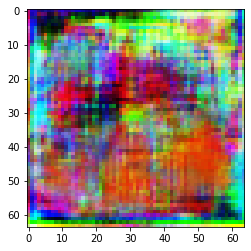

In [84]:
import matplotlib.pyplot as plt
noise = np.random.normal(0, 1, (1,100))
#print(noise)
#print(np.random.normal(0,1, (1,100)))
gan_img = generator.predict(noise)
print(discriminator.predict(gan_img))
img = 0.5*gan_img[0] + 0.5
plt.imshow(img)
#plt.imshow(gan_img)
plt.show()

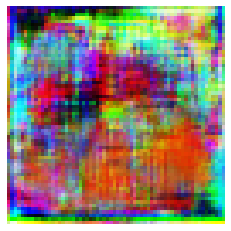

In [85]:
plt.imshow(img)
plt.axis('off')
plt.savefig('generated_anime.png', dpi=300, bbox_inches='tight')

Discriminator is receiving the images from both real/training images and generated images or the fake images ,so while calculating discriminator’s loss we have to add loss due of real images and also due of fake images both networks are trained simultaneously so we need two optimizers for both generator and discriminator both. we want from discriminator to output the probabilities close to 1 if the images are real and close to 0 if the images are fake.

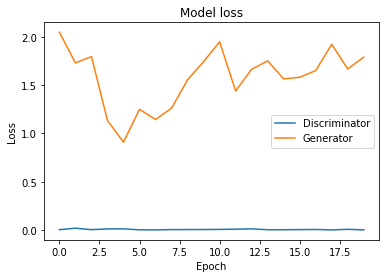

In [86]:
# plotting the metrics
plt.plot(dc_loss)
plt.plot(gn_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

# Model 2

Building the Model 2 with different hyperparameters momentum = 0.9, alpha =  0.3 and also using adam optimizer with learning rate = 0.003, beta_1(exponential decay rate) = 0.5, dropout rate = 0.25, maximum number of epochs = 100.

In [143]:
def build_generator1():
    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    print(noise)
    
    model = Sequential()
    model.add(Dense(64 * 4 * 4,activation="relu", input_shape=noise_shape))
    model.add(Reshape((4,4,64)))
    model.add(BatchNormalization(momentum=0.9))
    
    model.add(UpSampling2D())
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.9))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.9))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.9))

    model.add(UpSampling2D())
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    output_img = model(noise)

    return Model(noise, output_img)

In [144]:
def build_discriminator1():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

In [145]:
# Build and compile the generator
generator = build_generator1()
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.003, beta_1=0.5))

Tensor("input_21:0", shape=(None, 100), dtype=float32)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1024)              103424    
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
up_sampling2d_32 (UpSampling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 8, 8, 32)          18464     
_________________________________________________________________
activation_44 (Activation)   (None, 8, 8, 32)          0         
________________________________________________________________

In [146]:
# The generator takes noise as input and generated imgs
noise = Input(shape=(100,))
generated_image = generator(noise)

In [147]:
# Build and compile the discriminator
discriminator = build_discriminator1()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0004, beta_1=0.5), metrics=['binary_accuracy'])
discriminator.trainable = False



Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_80 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 16, 16, 64)      

In [148]:
# The valid takes generated images as input and determines validity
validity = discriminator(generated_image)

gan = Model(noise, validity, name = 'adversarial')
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0004,beta_1=0.5), metrics=['binary_accuracy'])
gan.summary()

Model: "adversarial"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_15 (Model)             (None, 64, 64, 3)         218851    
_________________________________________________________________
sequential_17 (Sequential)   (None, 1)                 1574465   
Total params: 1,793,316
Trainable params: 218,275
Non-trainable params: 1,575,041
_________________________________________________________________


In [149]:
disc_loss=[]
gene_loss=[]
def train(epochs, batch_size, save_interval):
    global discriminator, generator, gan
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):

        #  Train Discriminator
        real_ids = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[real_ids]

        noise = np.random.normal(0, 1, (half_batch, 100))
        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        real_loss = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        fake_loss = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d1_loss = 0.5 * np.add(real_loss, fake_loss)
        print(d1_loss[0])
        #  Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g1_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        print(g1_loss)
        # Plot the progress
        print ("%d [D loss: %f] [G loss: %f]" % (epoch, d1_loss[0], g1_loss[0]))
        #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        disc_loss.append(d1_loss[0])
        gene_loss.append(g1_loss[0])
        # If at save interval => save generated image samples
         # If at save interval => save generated image samples
        if epoch % save_interval == 0:
        
            gen_imgs = 0.5 * gen_imgs + 0.5
            fig, axs = plt.subplots(5, 5)
            for i in range(5):
                for j in range(5):
                    axs[i,j].imshow(gen_imgs[i*5+j])
                    axs[i,j].axis('off')

            fig.savefig("results/animes_%d.png" % epoch, dpi=600, bbox_inches='tight')
            plt.close() 

In [150]:
train(epochs=100, batch_size=256, save_interval=2)

1.8315978
[0.6685042, 0.72265625]
0 [D loss: 1.831598] [G loss: 0.668504]
0.42294252
[0.7410909, 0.23828125]
1 [D loss: 0.422943] [G loss: 0.741091]
0.2564405
[0.80880225, 0.1015625]
2 [D loss: 0.256440] [G loss: 0.808802]
0.3471045
[0.8045244, 0.17578125]
3 [D loss: 0.347104] [G loss: 0.804524]
0.18623753
[0.8087994, 0.24609375]
4 [D loss: 0.186238] [G loss: 0.808799]
0.1385518
[0.8681951, 0.1953125]
5 [D loss: 0.138552] [G loss: 0.868195]
0.09457126
[1.0058355, 0.13671875]
6 [D loss: 0.094571] [G loss: 1.005836]
0.08178616
[0.96033764, 0.1953125]
7 [D loss: 0.081786] [G loss: 0.960338]
0.04395074
[0.92001104, 0.30078125]
8 [D loss: 0.043951] [G loss: 0.920011]
0.03514373
[0.8324131, 0.4375]
9 [D loss: 0.035144] [G loss: 0.832413]
0.030920051
[0.8077304, 0.47265625]
10 [D loss: 0.030920] [G loss: 0.807730]
0.020792387
[0.68899125, 0.56640625]
11 [D loss: 0.020792] [G loss: 0.688991]
0.02704457
[0.65966713, 0.6328125]
12 [D loss: 0.027045] [G loss: 0.659667]
0.026822325
[0.6521183, 0.6

[[0.81487614]]


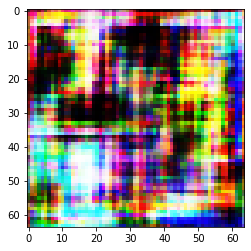

In [151]:
import matplotlib.pyplot as plt
noise = np.random.normal(0, 1, (1,100))
#print(noise)
gan_img = generator.predict(noise)
print(discriminator.predict(gan_img))
img = 0.5*gan_img[0] + 0.5
plt.imshow(img)
#plt.imshow(gan_img)
plt.show()

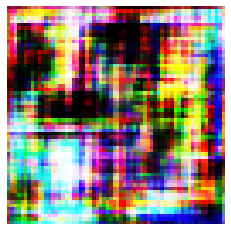

In [152]:
plt.imshow(img)
plt.axis('off')
plt.savefig('generated_anime.png', dpi=300, bbox_inches='tight')

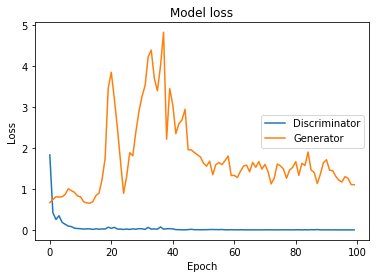

In [153]:
# plotting the metrics
plt.plot(disc_loss)
plt.plot(gene_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

Further increasing the size of the epochs to see if the image quality improves along with the hyperparameter values as both the generator loss and discriminator loss is comparitively less and discriminator loss is not completely converging to zero.

# Model 3

with varying hyperparameters learning rate - 0.0008, alpha = 0.3 and momentum = 0.8 with dropout rate in both generator and discriminator with a value of 0.3, batch_size = 64

In [133]:
def generator1():
    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    print(noise)
    
    model = Sequential()
    model.add(Dense(64 * 4 * 4,activation="relu", input_shape=noise_shape))
    model.add(Reshape((4,4,64)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.3))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.3))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.3))
    
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.3))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(16, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    output_img = model(noise)

    return Model(noise, output_img)

In [134]:
# Build and compile the generator
generator = generator1()
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0008, beta_1=0.6))

Tensor("input_19:0", shape=(None, 100), dtype=float32)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              103424    
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
dropout_40 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_28 (UpSampling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 8, 8, 128)         73856     
________________________________________________________________

In [135]:
def discriminator1():
    model = Sequential()
    img = Input(shape=img_size)
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.3))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.3))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.3))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.3))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    validity = model(img)
    
    return Model(img, validity)

In [136]:
# Build and compile the discriminator
discriminator = build_discriminator1()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0008, beta_1=0.6), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 16, 16, 64)      

In [137]:
# The generator takes noise as input and generated imgs
noise = Input(shape=(100,))
generated_image = generator(noise)

In [138]:
# The valid takes generated images as input and determines validity
validity = discriminator(generated_image)

gan = Model(noise, validity, name = 'adversarial')
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0008,beta_1=0.6), metrics=['accuracy'])
#gan.summary()

In [139]:
des_loss = []
gen_loss = []
def training(epochs, batch_size, save_interval):
    global discriminator, generator, gan
    half_batch = int(batch_size / 2)
    print(half_batch)
    for epoch in range(epochs):

        #  Train Discriminator
        real_ids = np.random.randint(0, X_train.shape[0], half_batch)
        #print(real_ids)
        real_imgs = X_train[real_ids]

        noise = np.random.normal(0, 1, (half_batch, 100))
        #print(noise)
        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)
        #print(gen_imgs)

        # Train the discriminator
        real_loss = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        #print(real_loss)
        fake_loss = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        #print(fake_loss)
        d_loss = 0.5 * np.add(real_loss, fake_loss)
        #print(d_loss)
        #  Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        #print(noise)
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        #print(g_loss)
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
        des_loss.append(d_loss[0])
        gen_loss.append(g_loss)
        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
        
            gen_imgs = 0.5 * gen_imgs + 0.5
            fig, axs = plt.subplots(5, 5)
            for i in range(5):
                for j in range(5):
                    axs[i,j].imshow(gen_imgs[i*5+j])
                    axs[i,j].axis('off')

            fig.savefig("Final/animes_%d.png" % epoch, dpi=600, bbox_inches='tight')
            plt.close()    


In [140]:
training(epochs=200, batch_size = 64, save_interval=10)

32
0 [D loss: 5.261747, acc.: 26.56%] [G loss: 0.577320]
1 [D loss: 2.328241, acc.: 50.00%] [G loss: 1.027018]
2 [D loss: 0.443866, acc.: 81.25%] [G loss: 1.467476]
3 [D loss: 0.707432, acc.: 84.38%] [G loss: 1.167035]
4 [D loss: 0.146333, acc.: 95.31%] [G loss: 0.547954]
5 [D loss: 0.077015, acc.: 95.31%] [G loss: 0.299540]
6 [D loss: 0.421786, acc.: 82.81%] [G loss: 0.941745]
7 [D loss: 0.030299, acc.: 98.44%] [G loss: 1.720407]
8 [D loss: 0.184718, acc.: 95.31%] [G loss: 0.770986]
9 [D loss: 0.050991, acc.: 98.44%] [G loss: 0.343508]
10 [D loss: 0.023641, acc.: 100.00%] [G loss: 0.196464]
11 [D loss: 0.003102, acc.: 100.00%] [G loss: 0.114099]
12 [D loss: 0.001800, acc.: 100.00%] [G loss: 0.021406]
13 [D loss: 0.011620, acc.: 100.00%] [G loss: 0.077766]
14 [D loss: 0.171427, acc.: 95.31%] [G loss: 0.081243]
15 [D loss: 0.027641, acc.: 98.44%] [G loss: 0.303435]
16 [D loss: 0.007533, acc.: 100.00%] [G loss: 0.427628]
17 [D loss: 0.099650, acc.: 95.31%] [G loss: 0.505852]
18 [D loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31 [D loss: 0.000011, acc.: 100.00%] [G loss: 6.017715]
32 [D loss: 0.003654, acc.: 100.00%] [G loss: 4.234263]
33 [D loss: 0.000344, acc.: 100.00%] [G loss: 3.343121]
34 [D loss: 0.000262, acc.: 100.00%] [G loss: 2.401930]
35 [D loss: 0.000375, acc.: 100.00%] [G loss: 2.124249]
36 [D loss: 0.012861, acc.: 100.00%] [G loss: 1.806999]
37 [D loss: 0.023470, acc.: 98.44%] [G loss: 3.251276]
38 [D loss: 0.000010, acc.: 100.00%] [G loss: 2.505455]
39 [D loss: 0.001934, acc.: 100.00%] [G loss: 2.629365]
40 [D loss: 0.010463, acc.: 100.00%] [G loss: 3.130305]
41 [D loss: 0.000006, acc.: 100.00%] [G loss: 5.664900]
42 [D loss: 0.000040, acc.: 100.00%] [G loss: 4.891178]
43 [D loss: 0.000065, acc.: 100.00%] [G loss: 4.308989]
44 [D loss: 0.000210, acc.: 100.00%] [G loss: 4.509471]
45 [D loss: 0.000624, acc.: 100.00%] [G loss: 2.133523]
46 [D loss: 0.000062, acc.: 100.00%] [G loss: 2.638731]
47 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.780775]
48 [D loss: 0.000092, acc.: 100.00%] [G loss: 1.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

91 [D loss: 2.432249, acc.: 79.69%] [G loss: 28.245995]
92 [D loss: 1.063697, acc.: 85.94%] [G loss: 32.224495]
93 [D loss: 0.662255, acc.: 89.06%] [G loss: 26.486198]
94 [D loss: 0.232100, acc.: 96.88%] [G loss: 32.463528]
95 [D loss: 0.000127, acc.: 100.00%] [G loss: 22.219612]
96 [D loss: 0.012904, acc.: 98.44%] [G loss: 11.536308]
97 [D loss: 0.156468, acc.: 96.88%] [G loss: 8.264788]
98 [D loss: 0.015230, acc.: 100.00%] [G loss: 12.456621]
99 [D loss: 0.778640, acc.: 87.50%] [G loss: 12.696404]
100 [D loss: 0.302186, acc.: 93.75%] [G loss: 19.639488]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

101 [D loss: 0.001376, acc.: 100.00%] [G loss: 23.725319]
102 [D loss: 0.259448, acc.: 96.88%] [G loss: 17.812960]
103 [D loss: 0.000012, acc.: 100.00%] [G loss: 12.326567]
104 [D loss: 0.000001, acc.: 100.00%] [G loss: 7.293158]
105 [D loss: 0.000000, acc.: 100.00%] [G loss: 6.052065]
106 [D loss: 0.662555, acc.: 98.44%] [G loss: 3.584484]
107 [D loss: 0.000019, acc.: 100.00%] [G loss: 2.653490]
108 [D loss: 0.016898, acc.: 98.44%] [G loss: 3.501758]
109 [D loss: 0.000750, acc.: 100.00%] [G loss: 3.785210]
110 [D loss: 0.141533, acc.: 98.44%] [G loss: 5.217544]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


111 [D loss: 0.000000, acc.: 100.00%] [G loss: 7.297214]
112 [D loss: 0.000000, acc.: 100.00%] [G loss: 7.001784]
113 [D loss: 0.000000, acc.: 100.00%] [G loss: 5.204408]
114 [D loss: 0.000000, acc.: 100.00%] [G loss: 5.740834]
115 [D loss: 0.000000, acc.: 100.00%] [G loss: 6.511913]
116 [D loss: 0.000000, acc.: 100.00%] [G loss: 5.619686]
117 [D loss: 0.000000, acc.: 100.00%] [G loss: 6.266606]
118 [D loss: 0.000000, acc.: 100.00%] [G loss: 4.753176]
119 [D loss: 0.000000, acc.: 100.00%] [G loss: 5.846490]
120 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.545375]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

121 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.533702]
122 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.884969]
123 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.872355]
124 [D loss: 0.000000, acc.: 100.00%] [G loss: 4.515270]
125 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.044568]
126 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.168888]
127 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.240569]
128 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.494497]
129 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.584859]
130 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.826555]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

131 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.512338]
132 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.943636]
133 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.253546]
134 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.678298]
135 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.249187]
136 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.839847]
137 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.499727]
138 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.608736]
139 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.888561]
140 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.453422]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

141 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.744456]
142 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.141011]
143 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.768498]
144 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.201191]
145 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.838164]
146 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.722056]
147 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.784032]
148 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.772944]
149 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.095215]
150 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.603439]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

151 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.731507]
152 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.665480]
153 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.965928]
154 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.153154]
155 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.898763]
156 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.275993]
157 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.928349]
158 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.370377]
159 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.124482]
160 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.577217]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

161 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.920355]
162 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.824512]
163 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.197486]
164 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.684917]
165 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.491516]
166 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.689166]
167 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.532424]
168 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.692449]
169 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.262036]
170 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.436022]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

171 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.881950]
172 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.363534]
173 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.542283]
174 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.288742]
175 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.567726]
176 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.417239]
177 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.208421]
178 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.499375]
179 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.214038]
180 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.291008]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

181 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.267475]
182 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.251761]
183 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.211951]
184 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.216434]
185 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.219476]
186 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.310981]
187 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.484789]
188 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.152138]
189 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.176350]
190 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.238950]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

191 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.077013]
192 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.052653]
193 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.277782]
194 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.300877]
195 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.368660]
196 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.256081]
197 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.360539]
198 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.256899]
199 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.339535]


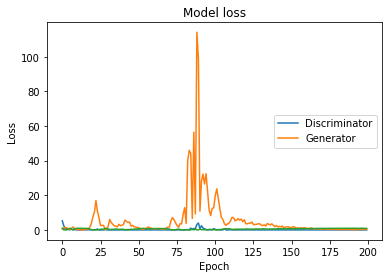

In [141]:
# plotting the metrics
plt.plot(des_loss)
plt.plot(gen_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.99029255]]


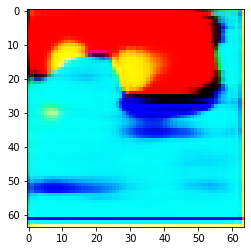

In [142]:
import matplotlib.pyplot as plt
noise = np.random.normal(0, 1, (1,100))
#print(noise)
gan_img = generator.predict(noise)
print(discriminator.predict(gan_img))
img = 0.5*gan_img[0] + 0.5
plt.imshow(img)
#plt.imshow(gan_img)
plt.show()

# Conclusion

Explain how the GAN works. Did this GAN work well. Why or why not? Which hyperparameters are most important? Why? Back up your reasoning with data.                                                                                         

Working of GAN explained above along with the code.   

For all the above models, important hyperparameters varied (trial and error approach) are learning rate (0.003,0.0008,0.0002) , beta(exponential decay rate - 0.5), number of epochs (50,100,200), batch size (64,128,256), momentum (0.8,0.9), alpha values (0.25,0.3), dropout rate (0.25,03).

Model 1 for 50 epochs  with hyperparameters - learning rate - 0.0002, momentum - 0.8, beta_1 = 0.5, batch_size = 64, alpha - 0.25, dropout rate - 0.25  was the pictures seemed still blurry and not clear compared to the Model 2 and model 3. My GAN did not work so well compared to the other two models either with respect to the images clarity or the generator and discriminator's loss

Model 2 for 100 epochs with momentum = 0.9, alpha = 0.3 and also using adam optimizer with learning rate = 0.003, beta_1(exponential decay rate) = 0.5, dropout rate = 0.25, maximum number of epochs = 100. The pictures still seems blurry and not clear compared to the Model 3. My GAN did not work so well compared to the other two models. But comparitively works better with generator and discriminator loss since it is the trade off between each other as the discriminator loss is not completely converging to zero compared to Model 3 although the image is bit clear and not blurry compared to model 3.

Model 3 for 200 epochs with varying hyperparameters learning rate - 0.0008, alpha = 0.3 and momentum = 0.8 with dropout rate in both generator and discriminator with a value of 0.3, batch_size = 64, maximum number of epochs = 200. The pictures still seems still blurry but way better compared to the other two Models. So far on manually inspecting the quality of images model 3 looks best compared to the other two models. Model 3 was generated keeping in mind the problems with the other two models such as increasing the epoch size for more training required to generate fake images, generated image looks still noisy so changing drop out rate to 0.3, varying hyperparameter values to produce better images to be passed on to the discriminator.




# Readme

Install Python version>= 3.6 and tensorflow using "pip install tensorflow", to install PILLOW ==> "pip install pillow" with these installations and the jupyter notebook one should be able to run this file.

# Citations

1. https://towardsdatascience.com/understanding-and-optimizing-gans-going-back-to-first-principles-e5df8835ae18
2. https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
3. https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889
4. https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b
5. https://medium.com/coinmonks/celebrity-face-generation-using-gans-tensorflow-implementation-eaa2001eef86
6.https://github.com/nikbearbrown/INFO_7390/blob/master/Deep_Learning/Generative_Models/Generative%20Adversarial%20Networks%20Tutorial.ipynb
7. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

# Contributions

Individual Contribution - 20%                                                                       

External References - 80%

# License

Copyright 2020, Chaitanya Prasanna Kumar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.